# **Text Similarity Analysis Using Sentence Embeddings**

This notebook demonstrates how to analyze the similarity between different texts using sentence embeddings, visualizations, and outlier detection. We will explore variations of the well-known English pangram: **"The quick brown fox jumps over the lazy dog."** This sentence is widely used because it contains every letter of the English alphabet at least once.

## **Overview of the Example Texts:**
- The example texts include variations of the pangram with spelling errors, shortened versions, synonyms, and an entirely unrelated text.
- Our goal is to measure the semantic similarity between these texts and identify the most similar pairs, outliers, and key differences.

## **What We Will Do:**
1. Generate embeddings using the `sentence-transformers` library.
2. Visualize the similarity matrix using a heatmap.
3. Use t-SNE to cluster and visualize embeddings.
4. Detect outlier texts using the Local Outlier Factor algorithm.
5. Highlight differences between the most similar text pairs.




# Step 1. Install libraries
The optional flag -q installs "quietly" without printing out details of the installation.

In [21]:
# Install the required libraries if running in Google Colab
# Uncomment the line below if using Colab
!pip install sentence-transformers scikit-learn matplotlib seaborn -q

#Step 2: Importing Libraries

* SentenceTransformer: For generating sentence embeddings using pre-trained language models.
* cosine_similarity: For computing pairwise similarity between text embeddings.
* TSNE: For visualizing high-dimensional embeddings in 2D space.
* LocalOutlierFactor: For detecting potential outlier texts.
* seaborn and matplotlib: For creating heatmaps and scatter plots.
* difflib: For highlighting differences between two similar texts.





In [2]:
# Import libraries
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import difflib

# Step 3: Embedding Texts Using a Pre-trained Model

### Generating Sentence Embeddings
We are using the `sentence-transformers` library to convert each text into a dense vector representation. These embeddings capture the semantic meaning of the texts.

**get_embeddings**: This function takes a list of texts and generates embeddings using the *all-MiniLM-L6-v2* model, which is fast and effective for most applications.
https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

In [4]:
# Function: get_embeddings
def get_embeddings(texts, model_name="all-MiniLM-L6-v2"):
    """Generates sentence embeddings using SentenceTransformer."""
    model = SentenceTransformer(model_name)
    return model.encode(texts)

#Step 4: Plotting the Similarity Heatmap
### Similarity Heatmap
The heatmap visually shows the similarity scores between each pair of texts. The values are based on cosine similarity, where 1.0 means perfect similarity.


The function plots a heatmap of the cosine similarity between texts.

**annot=True**: Displays the similarity values on the heatmap.

**fmt=".2f"**: Ensures the values are rounded to two decimal places.
cmap =  stands for colormap, which defines the color scheme used to represent the data in the heatmap.

**cmap='viridis'** - 'viridis' is a popular colormap that transitions from dark purple (low values) to yellow-green (high values).



In [5]:
# Function: plot_similarity_heatmap
def plot_similarity_heatmap(texts, similarity_matrix):
    """Plots a heatmap of text similarity."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix,
                annot=True,
                fmt=".2f",
                cmap='viridis',
                xticklabels=[f"Text {i+1}" for i in range(len(texts))],
                yticklabels=[f"Text {i+1}" for i in range(len(texts))])
    plt.title("Text Similarity Heatmap")
    plt.show()

#Step 5: Visualizing Text Embeddings Using t-SNE
### Visualizing Clusters of Texts Using t-SNE
This function will create a plot showing how similar texts form clusters based on their embeddings.
Points that are closer together represent semantically similar texts.
t-SNE is used to reduce the high-dimensional embeddings to 2D for visualization.
perplexity=3: Controls the balance between local and global aspects of the data.


### **Note: What is t-SNE?**
t-SNE (t-Distributed Stochastic Neighbor Embedding) is a machine learning algorithm used for dimensionality reduction.

It is particularly effective for visualizing high-dimensional data by mapping it to a 2D or 3D space.  
t-SNE preserves the **local structure** of the data, meaning that points that are similar in the high-dimensional space remain close to each other in the lower-dimensional space.

It is commonly used for exploring clusters and relationships in datasets such as text, images, or embeddings.


In [6]:
# Function: plot_embedding_clusters
def plot_embedding_clusters(embeddings, texts, perplexity=3):
    """Visualizes text embeddings using t-SNE."""
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

    for i, txt in enumerate(texts):
        plt.text(embeddings_2d[i, 0] + 0.1, embeddings_2d[i, 1] + 0.1, f"Text {i+1}", fontsize=8)

    plt.title("Text Embeddings Visualization")
    plt.show()

# Step 6: Detecting Outlier Texts
### Outlier Detection
We use the `LocalOutlierFactor` algorithm to identify texts that are significantly different from the rest.
If a text is significantly different from the others, it will be flagged as an outlier.

## **What is Local Outlier Factor (LOF)?**
The **Local Outlier Factor** algorithm is an unsupervised anomaly detection method.

It identifies anomalies by comparing the **local density** of a point with that of its neighbors.  
Points that have a significantly lower density than their neighbors are flagged as outliers.

The **local outlier factor** is based on a concept of a **local density**, where locality is given by *k nearest neighbors*, whose distance is used to estimate the density. By comparing the local density of an object to the local densities of its neighbors, one can identify regions of similar density, and points that have a substantially lower density than their neighbors. These are considered to be outliers. (from Wikipedia: https://en.wikipedia.org/wiki/Local_outlier_factor)

In this case, LOF helps detect texts that are semantically different from the majority.


In [7]:
# Function: detect_outliers
def detect_outliers(embeddings, texts):
    """Detects outlier texts using LocalOutlierFactor."""
    # we compare the local density of a point to its 2 nearest neighbors.
    lof = LocalOutlierFactor(n_neighbors=2)
    #Fit the LOF model to the embeddings and predict outliers
    outlier_labels = lof.fit_predict(embeddings)
    # The model assigns -1 to outliers and 1 to normal points. Collect texts that are flagged as outliers (outlier label = -1)
    outliers = [texts[i] for i in range(len(outlier_labels)) if outlier_labels[i] == -1]

    if outliers:
        print("\nDetected Outliers:")
        for text in outliers:
            print(f"- {text}")
    else:
        print("\nNo significant outliers detected.")

#Step 7: Finding the Most Similar Text Pairs
Here we compare all pairs of texts and returns the most similar pairs based on cosine similarity.


In [22]:
# Function to find and sort most similar pairs
# This function identifies and ranks the most semantically similar pairs of texts based on cosine similarity scores.
def find_most_similar_pairs(texts, similarity_matrix):
    """Finds and sorts the most similar text pairs."""
    pairs = []
    for i in range(len(texts)):
        # Iterate through each pair of texts to compute pairwise similarity
        for j in range(i + 1, len(texts)):
            # Append a tuple containing indices of the two texts and their similarity score
            pairs.append((i, j, similarity_matrix[i][j]))
    # Sort the pairs by their similarity score in descending order, so the most similar pairs are at the top
    pairs.sort(key=lambda x: x[2], reverse=True)
    return pairs

#Step 8: Highlighting Differences Between Similar Texts
### Highlighting Differences
We use the `difflib` library to highlight differences between two similar texts.

In [9]:
# This function compares two input texts and highlights their differences.
def highlight_text_differences(text1, text2):
   # Generate a list of differences using difflib's ndiff function.
   # The '+' prefix indicates words that are present in text2 but not in text1.
   # The '-' prefix indicates words that are in text1 but not in text2.
    """Highlights differences between two texts."""
    diff = difflib.ndiff(text1.split(), text2.split())

    # Highlight words with a green color if they are additions in text2 (start with '+').
    # Ignore words that are deletions from text1 (start with '-').
    # Join the processed words into a single highlighted output string.
    highlighted = ' '.join([f"\033[92m{word}\033[0m" if word.startswith('+') else word for word in diff if not word.startswith('-')])
    return highlighted

#Step 9. Application to text analysis
This example embeds some variations on the pangram, *The quick brown fox jumps over the lazy dog*, including spelling mistakes and shortenings of the phrase. Another pangram and a somewhat unrelated phrase have been included for comparison.

#### **1. The quick brown fox jumps over the lazy dog.**
This is the original pangram used in typing and font demos as it contains all the letters of the alphabet.

#### **2. The quick rbown fox jumps over the lazy dog.**
This is a slightly modified version of the original sentence, with a minor spelling mistake ("rbown" instead of "brown"). This variation helps test how embeddings handle small spelling errors.

#### **3. teh fast fox jumps over the slow woofer.**
This sentence introduces multiple changes:
- **Spelling mistake:** "teh" instead of "the".
- **Synonym replacement:** "fast" replaces "quick", and "slow woofer" replaces "lazy dog".  
It is used to evaluate how well the model generalizes semantic meaning.

#### **4. a quick brown fox jmps over lazy dog.**
Another variation with a spelling error ("jmps" instead of "jumps") and missing articles ("the" is omitted). This variation tests how robust the model is to missing or mistyped words.

#### **5. brown fox jumping over dog**
A shortened version of the sentence, omitting "quick," "the," and other words. This text checks whether embeddings still capture the core meaning despite fewer words.

#### **6. fox > dog**
A symbolic expression representing the relationship between a fox and a dog. This phrase is included to test how embeddings interpret minimal and abstract inputs.

#### **7. The five boxing wizards jump quickly.**
Another pangram with no spelling errors, used to see how embeddings relate two different but grammatically correct sentences.

#### **8. Lorem ipsum dolor sit amet...**
A completely unrelated Latin filler text commonly used in design. It serves as a control case to test how dissimilar and unrelated texts are handled by the model.


In [11]:
texts = [
        'The quick brown fox jumps over the lazy dog.',
        'The quick rbown fox jumps over the lazy dog.',
        'teh fast fox jumps over the slow woofer.',
        'a quick brown fox jmps over lazy dog.',
        'brown fox jumping over dog',
        'fox > dog',
        'The five boxing wizards jump quickly.',
        'Lorem ipsum dolor sit amet...'
    ]

#Step 10. **Generating Embeddings and Calculating Similarity**

In this step, we generate sentence embeddings for each text using functions above
The embeddings capture the semantic meaning of each sentence and convert them into high-dimensional dense vectors.

Once we have the embeddings, we calculate the pairwise similarity between the texts using **cosine similarity**.  
Cosine similarity measures the angle between two vectors: values close to 1 indicate high similarity, while values near 0 or -1 indicate low similarity.


In [13]:
# Get embeddings and similarity matrix
# Generate sentence embeddings for the input texts
# Each text is transformed into a high-dimensional dense vector representing its semantic mea
embeddings = get_embeddings(texts)

# Compute pairwise cosine similarities between the embeddings
# The similarity score ranges from -1 (completely different) to 1 (identical), with values
similarity_matrix = cosine_similarity(embeddings)



Lower similarity scores will be shown in darker purples.
Higher similarity scores will be shown in brighter yellow-greens.

#Step 11. **Similarity heatmap**

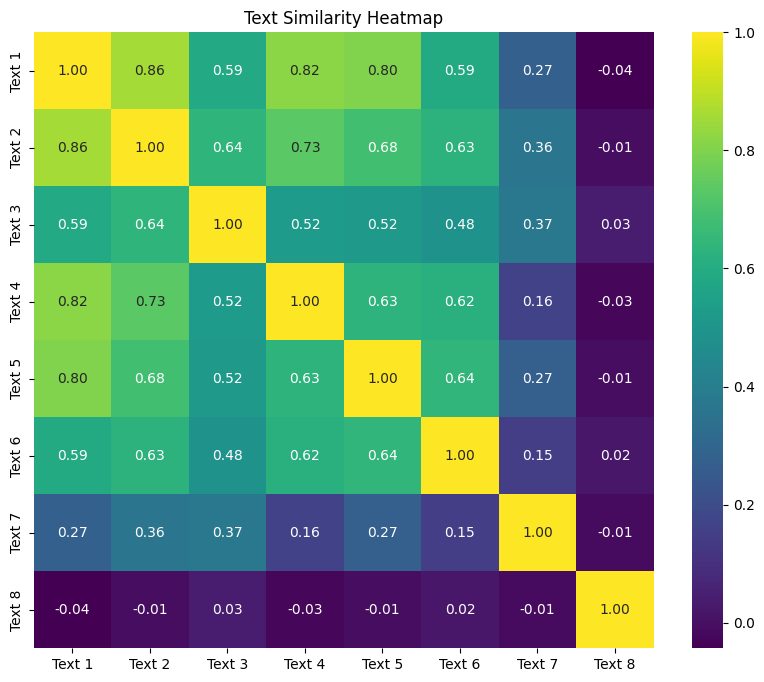

In [14]:
plot_similarity_heatmap(texts, similarity_matrix)


## **Takeaways from the Similarity Heatmap**

1. **High Similarity Scores for Minor Variations**:
   - Texts with small spelling mistakes, such as "The quick rbown fox..." compared to the original pangram, show **high similarity scores**. This indicates that the embedding model is robust to small errors in spelling and can still capture semantic similarity.

2. **Lower Similarity for Synonym and Structural Changes**:
   - Sentences like "teh fast fox jumps over the slow woofer," which involve synonym replacements and structural changes, have **moderate similarity scores**. This shows that while the model recognizes some similarity, it penalizes changes in word meaning and structure.

3. **Minimal Similarity for Shortened or Abstract Expressions**:
   - Shortened sentences such as "fox > dog" exhibit **low similarity scores**, as they lose key descriptive information from the original phrase. This demonstrates that minimal or abstract inputs can lead to lower semantic understanding.

4. **Control Case with Unrelated Text**:
   - The Latin filler text, "Lorem ipsum dolor sit amet," has **very low similarity scores** with most texts. This confirms that the model correctly identifies semantically unrelated content.




## Step 12. **Visualizing Clusters of Text Embeddings with t-SNE**

In this step, we use t-SNE (t-Distributed Stochastic Neighbor Embedding) to reduce the high-dimensional embeddings into 2D space for visualization.  
t-SNE helps preserve the local structure of the embeddings, making it easier to visually identify clusters and relationships between similar texts.



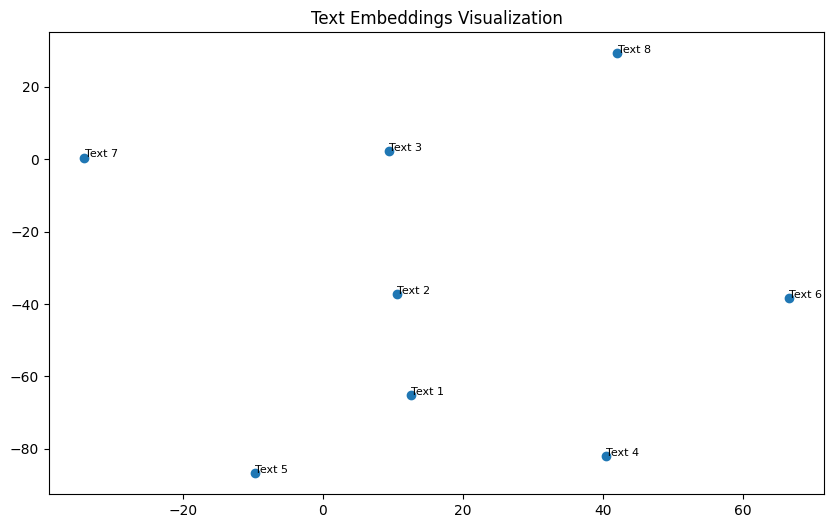

In [15]:
plot_embedding_clusters(embeddings, texts, perplexity=3)


### **Key Points:**
- Texts that are semantically similar will appear closer together.
- Outliers or dissimilar texts will be positioned farther apart.
- The `perplexity` parameter controls how t-SNE balances attention between local and global structures.


#Step 13. **Detect Outliers**

In this step, we use the Local Outlier Factor (LOF) algorithm to identify texts that are significantly different from the others (see function above).  


In [16]:
detect_outliers(embeddings, texts)


Detected Outliers:
- Lorem ipsum dolor sit amet...


#Step 14. **Print most similar text pairs:**

In [23]:
print("\nMost Similar Text Pairs:")
# Find and rank all pairs of texts by their similarity score
pairs = find_most_similar_pairs(texts, similarity_matrix)
# Loop through the top 3 most similar pairs
for i, j, score in pairs[:3]:  # try here to change the number of pairs
  print(f"\nSimilarity Score: {score:.3f}")
  print(f"Text {i+1}: {texts[i]}")
  print(f"Text {j+1}: {texts[j]}")
  print("Highlighted Differences:")
  # Highlight the differences between the two texts to understand what drives their similarity
  print(highlight_text_differences(texts[i], texts[j]))


Most Similar Text Pairs:

Similarity Score: 0.860
Text 1: The quick brown fox jumps over the lazy dog.
Text 2: The quick rbown fox jumps over the lazy dog.
Highlighted Differences:
  The   quick ?  -
 + rbown ? +
   fox   jumps   over   the   lazy   dog.

Similarity Score: 0.820
Text 1: The quick brown fox jumps over the lazy dog.
Text 4: a quick brown fox jmps over lazy dog.
Highlighted Differences:
+ a   quick   brown   fox ?  -
 + jmps   over   lazy   dog.

Similarity Score: 0.802
Text 1: The quick brown fox jumps over the lazy dog.
Text 5: brown fox jumping over dog
Highlighted Differences:
  brown   fox + jumping   over ?    -
 + dog

Similarity Score: 0.734
Text 2: The quick rbown fox jumps over the lazy dog.
Text 4: a quick brown fox jmps over lazy dog.
Highlighted Differences:
+ a   quick ?  -
 + brown ? +
   fox ?  -
 + jmps   over   lazy   dog.
